# Green-Ampt Parameter Estimation

This interactive notebook allows you to:
1. **Draw** an Area of Interest (AOI) on an interactive map, or
2. **Import** an existing shapefile as the AOI
3. Fetch SSURGO soil data (locally or via PySDA)
4. Generate Green-Ampt infiltration parameter rasters

## Setup
Run the cells below to import required libraries and initialize the tool.

In [1]:
# Import standard libraries
from pathlib import Path
import json
import tempfile
import logging

# Import geospatial libraries
import geopandas as gpd
from shapely.geometry import shape, mapping

# Import interactive mapping libraries
from ipyleaflet import (
    Map,
    DrawControl,
    GeoData,
    basemaps,
    LayersControl,
    WidgetControl,
)
from ipywidgets import (
    VBox,
    HBox,
    Button,
    FileUpload,
    Text,
    Dropdown,
    FloatText,
    Checkbox,
    Output,
    HTML,
)

# Import Green-Ampt tool modules
from green_ampt_tool.config import LocalSSURGOPaths, PipelineConfig
from green_ampt_tool.workflow import run_pipeline
from green_ampt_tool.data_access import read_aoi

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(name)s - %(message)s",
)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Step 1: Define Area of Interest (AOI)

Choose one of the following methods:
- **Option A**: Draw AOI on the interactive map below
- **Option B**: Upload an existing shapefile

### Option A: Draw AOI on Map

In [4]:
# Global variable to store the AOI
aoi_geometry = None
aoi_source = None

# Create interactive map centered on US
m = Map(
    basemap=basemaps.OpenStreetMap.Mapnik,
    center=(39.8283, -98.5795),  # Center of US
    zoom=4,
    scroll_wheel_zoom=True,
)

# Add drawing controls
draw_control = DrawControl(
    polygon={"shapeOptions": {"fillColor": "#6be5c3", "color": "#6be5c3", "fillOpacity": 0.3}},
    rectangle={"shapeOptions": {"fillColor": "#efed69", "color": "#efed69", "fillOpacity": 0.3}},
    polyline={},
    circle={},
    circlemarker={},
    marker={},
)

output_widget = Output()

def handle_draw(target, action, geo_json):
    global aoi_geometry, aoi_source
    with output_widget:
        output_widget.clear_output()
        if action == "created":
            aoi_geometry = geo_json
            aoi_source = "drawn"
            print(f"✓ AOI {action}: {geo_json['geometry']['type']}")
            print("  Ready to proceed to the next step!")
        elif action == "deleted":
            aoi_geometry = None
            aoi_source = None
            print("✗ AOI deleted. Please draw a new area.")

draw_control.on_draw(handle_draw)
m.add_control(draw_control)
m.add_control(LayersControl())

# Display map and output
display(HTML("<h4>Draw your Area of Interest:</h4>"))
display(HTML("<p>Use the drawing tools on the left to draw a <strong>polygon</strong> or <strong>rectangle</strong> representing your study area.</p>"))
display(m)
display(output_widget)

HTML(value='<h4>Draw your Area of Interest:</h4>')

HTML(value='<p>Use the drawing tools on the left to draw a <strong>polygon</strong> or <strong>rectangle</stro…

Map(center=[39.8283, -98.5795], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Output()

### Option B: Upload Shapefile

Upload a zipped shapefile (.zip containing .shp, .shx, .dbf, .prj files) or individual shapefile components.

In [ ]:
upload_widget = FileUpload(
    accept=".shp,.shx,.dbf,.prj,.zip,.gpkg,.geojson",
    multiple=True,
    description="Upload AOI:",
)

upload_output = Output()
upload_button = Button(description="Load Shapefile", button_style="primary")

def load_uploaded_shapefile(b):
    global aoi_geometry, aoi_source
    with upload_output:
        upload_output.clear_output()
        if not upload_widget.value:
            print("⚠ Please upload files first")
            return
        
        try:
            # Create temporary directory for uploaded files
            temp_dir = Path(tempfile.mkdtemp())
            
            # Save uploaded files
            uploaded_files = []
            for uploaded_file in upload_widget.value:
                file_path = temp_dir / uploaded_file.name
                with open(file_path, "wb") as f:
                    f.write(uploaded_file.content)
                uploaded_files.append(file_path)
                print(f"  Saved: {uploaded_file.name}")
            
            # Find the shapefile or other vector format
            shp_files = [f for f in uploaded_files if f.suffix == ".shp"]
            gpkg_files = [f for f in uploaded_files if f.suffix == ".gpkg"]
            geojson_files = [f for f in uploaded_files if f.suffix == ".geojson"]
            
            vector_file = None
            if shp_files:
                vector_file = shp_files[0]
            elif gpkg_files:
                vector_file = gpkg_files[0]
            elif geojson_files:
                vector_file = geojson_files[0]
            else:
                print("⚠ No shapefile (.shp), geopackage (.gpkg), or GeoJSON (.geojson) found")
                return
            
            # Read the vector file
            gdf = gpd.read_file(vector_file)
            print(f"✓ Loaded {len(gdf)} feature(s) from {vector_file.name}")
            print(f"  CRS: {gdf.crs}")
            
            # Convert to WGS84 for map display
            gdf_wgs84 = gdf.to_crs("EPSG:4326")
            
            # Store as GeoJSON
            geojson_data = json.loads(gdf_wgs84.to_json())
            
            # Store first feature or union of all features
            if len(geojson_data["features"]) == 1:
                aoi_geometry = geojson_data["features"][0]
            else:
                # Union all geometries
                union_geom = gdf_wgs84.unary_union
                aoi_geometry = {
                    "type": "Feature",
                    "geometry": mapping(union_geom),
                    "properties": {},
                }
            
            aoi_source = "uploaded"
            
            # Display on map
            geo_data = GeoData(
                geo_dataframe=gdf_wgs84,
                style={"color": "red", "fillColor": "red", "fillOpacity": 0.3, "weight": 2},
                name="Uploaded AOI",
            )
            m.add_layer(geo_data)
            
            # Zoom to AOI
            bounds = gdf_wgs84.total_bounds  # minx, miny, maxx, maxy
            m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])
            
            print("✓ AOI loaded and displayed on map")
            print("  Ready to proceed to the next step!")
            
        except Exception as e:
            print(f"✗ Error loading shapefile: {e}")
            aoi_geometry = None
            aoi_source = None

upload_button.on_click(load_uploaded_shapefile)

display(HTML("<h4>Or upload an existing shapefile:</h4>"))
display(VBox([upload_widget, upload_button, upload_output]))

## Step 2: Configure Pipeline Settings

Set up the parameters for the Green-Ampt parameter generation.

In [5]:
# Configuration widgets
data_source_widget = Dropdown(
    options=["pysda", "local"],
    value="pysda",
    description="Data Source:",
    tooltip="Use 'pysda' to fetch data from NRCS online, or 'local' to use downloaded SSURGO files",
)

output_dir_widget = Text(
    value="./outputs",
    description="Output Dir:",
    tooltip="Directory where results will be saved",
)

output_crs_widget = Text(
    value="EPSG:32617",
    description="Output CRS:",
    tooltip="Coordinate Reference System for output rasters (e.g., EPSG:32617 for UTM Zone 17N)",
)

output_resolution_widget = FloatText(
    value=30.0,
    description="Resolution (m):",
    tooltip="Pixel size in output CRS units",
)

depth_limit_widget = FloatText(
    value=30.0,
    description="Depth Limit (cm):",
    tooltip="Depth limit for soil horizon aggregation",
)

export_raw_widget = Checkbox(
    value=True,
    description="Export raw SSURGO data",
    tooltip="Save the fetched SSURGO datasets to disk",
)

# Local SSURGO file paths (only shown when data_source is 'local')
mupolygon_widget = Text(
    value="",
    description="Mupolygon:",
    placeholder="path/to/mupolygon.shp",
)

mapunit_widget = Text(
    value="",
    description="Mapunit:",
    placeholder="path/to/mapunit.txt",
)

component_widget = Text(
    value="",
    description="Component:",
    placeholder="path/to/component.txt",
)

chorizon_widget = Text(
    value="",
    description="Chorizon:",
    placeholder="path/to/chorizon.txt",
)

local_files_box = VBox(
    [mupolygon_widget, mapunit_widget, component_widget, chorizon_widget],
    layout={"display": "none"},
)

def on_data_source_change(change):
    if change["new"] == "local":
        local_files_box.layout.display = "block"
    else:
        local_files_box.layout.display = "none"

data_source_widget.observe(on_data_source_change, names="value")

# Display configuration
display(HTML("<h4>Pipeline Configuration:</h4>"))
display(
    VBox(
        [
            data_source_widget,
            output_dir_widget,
            output_crs_widget,
            output_resolution_widget,
            depth_limit_widget,
            export_raw_widget,
            local_files_box,
        ]
    )
)

HTML(value='<h4>Pipeline Configuration:</h4>')

## Step 3: Run the Pipeline

Execute the Green-Ampt parameter generation workflow.

In [6]:
run_button = Button(
    description="Generate Green-Ampt Parameters",
    button_style="success",
    icon="play",
)

run_output = Output()

def run_green_ampt_pipeline(b):
    with run_output:
        run_output.clear_output()
        
        # Validate AOI
        if aoi_geometry is None:
            print("✗ Error: No AOI defined. Please draw an area or upload a shapefile.")
            return
        
        print(f"Starting pipeline with AOI from: {aoi_source}")
        print("=" * 60)
        
        try:
            # Save AOI to temporary file
            temp_aoi_dir = Path(tempfile.mkdtemp())
            temp_aoi_path = temp_aoi_dir / "aoi.geojson"
            
            # Create GeoDataFrame from geometry
            geom = shape(aoi_geometry["geometry"])
            aoi_gdf = gpd.GeoDataFrame([{"geometry": geom}], crs="EPSG:4326")
            aoi_gdf.to_file(temp_aoi_path, driver="GeoJSON")
            print(f"✓ AOI saved to temporary file: {temp_aoi_path}")
            
            # Build configuration
            local_paths = None
            if data_source_widget.value == "local":
                if not all(
                    [
                        mupolygon_widget.value,
                        mapunit_widget.value,
                        component_widget.value,
                        chorizon_widget.value,
                    ]
                ):
                    print("✗ Error: All local SSURGO file paths are required when using local data source")
                    return
                
                local_paths = LocalSSURGOPaths(
                    mupolygon=Path(mupolygon_widget.value),
                    mapunit=Path(mapunit_widget.value),
                    component=Path(component_widget.value),
                    chorizon=Path(chorizon_widget.value),
                )
            
            config = PipelineConfig(
                aoi_path=temp_aoi_path,
                output_dir=Path(output_dir_widget.value),
                output_resolution=output_resolution_widget.value,
                output_crs=output_crs_widget.value,
                data_source=data_source_widget.value,
                local_ssurgo=local_paths,
                depth_limit_cm=depth_limit_widget.value,
                export_raw_data=export_raw_widget.value,
            )
            
            print(f"✓ Configuration created")
            print(f"  Output directory: {config.output_dir}")
            print(f"  Data source: {config.data_source}")
            print(f"  Resolution: {config.output_resolution} m")
            print(f"  CRS: {config.output_crs}")
            print("")
            
            # Run the pipeline
            print("Running pipeline...")
            run_pipeline(config)
            
            print("")
            print("=" * 60)
            print("✓ Pipeline completed successfully!")
            print(f"  Rasters: {config.raster_dir}")
            print(f"  Vectors: {config.vector_dir}")
            if config.export_raw_data and config.raw_data_dir:
                print(f"  Raw data: {config.raw_data_dir}")
            
        except Exception as e:
            print("")
            print("=" * 60)
            print(f"✗ Pipeline failed: {e}")
            import traceback
            traceback.print_exc()

run_button.on_click(run_green_ampt_pipeline)

display(HTML("<h4>Execute Pipeline:</h4>"))
display(VBox([run_button, run_output]))

HTML(value='<h4>Execute Pipeline:</h4>')

## Step 4: Visualize Results (Optional)

Load and display the generated parameter rasters.

2025-10-18 02:57:13,825 INFO matplotlib.font_manager - generated new fontManager


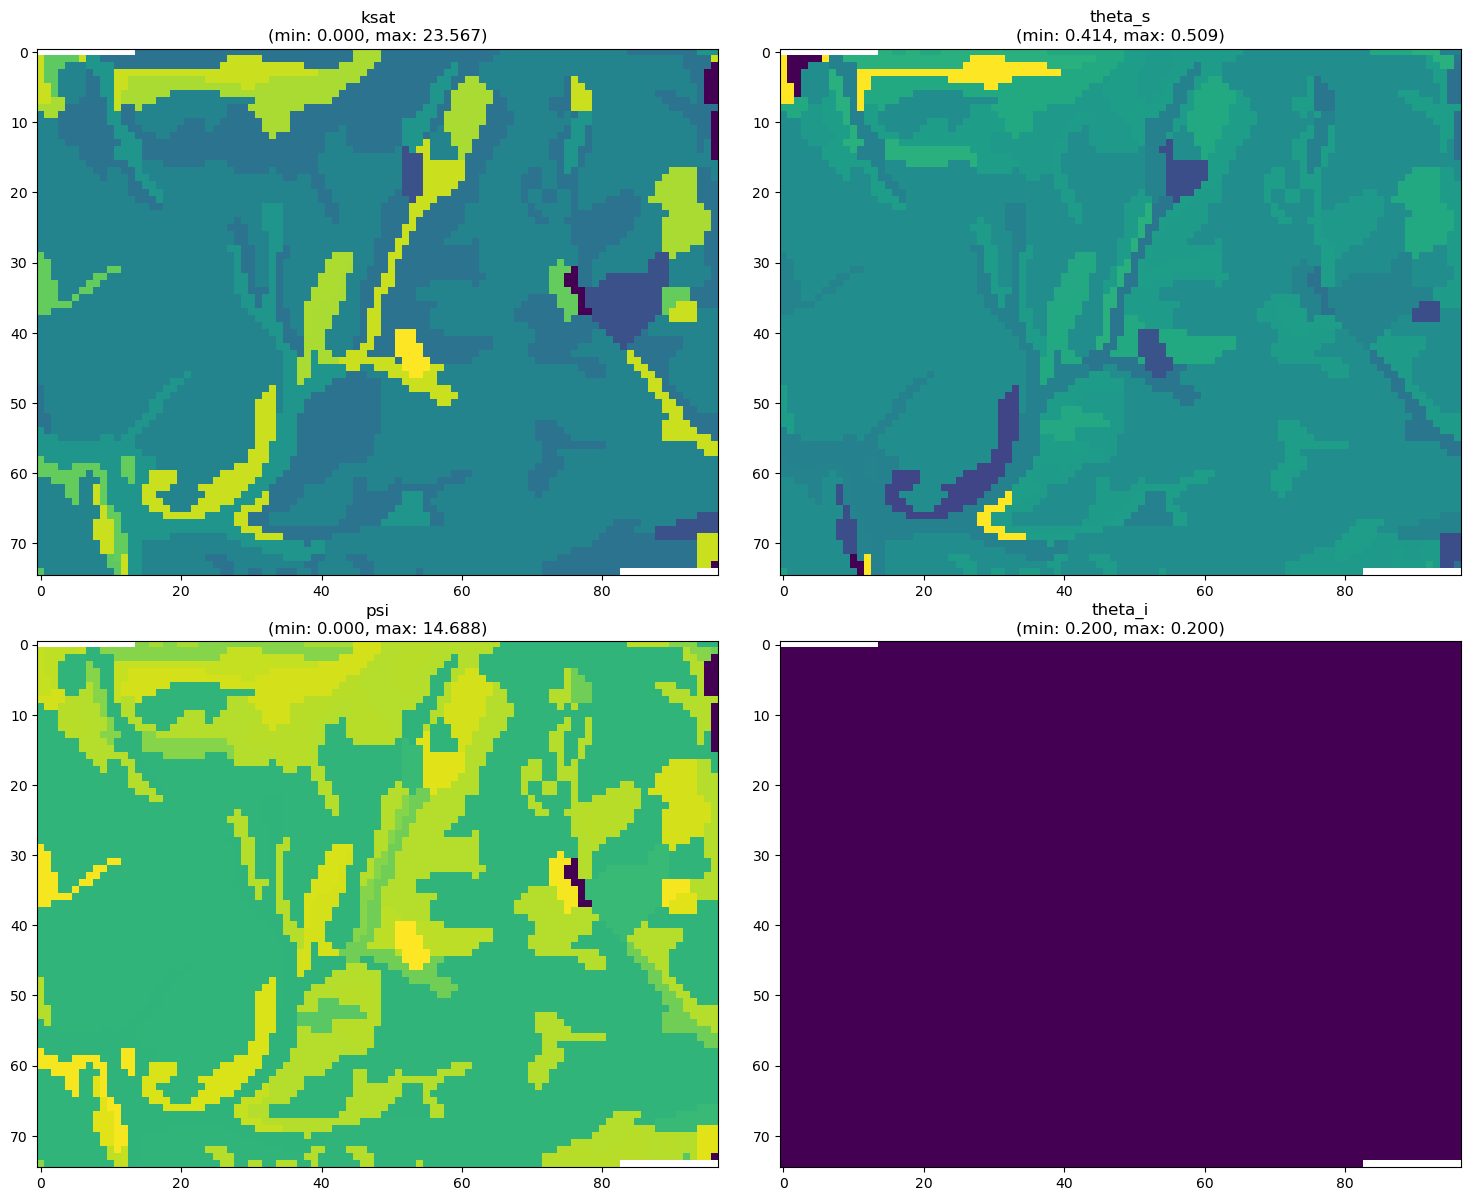

In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(output_dir, parameters=["ksat", "theta_s", "psi", "theta_i"]):
    """Visualize the generated Green-Ampt parameter rasters."""
    output_path = Path(output_dir) / "rasters"
    
    if not output_path.exists():
        print(f"Output directory not found: {output_path}")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for idx, param in enumerate(parameters):
        raster_files = list(output_path.glob(f"*{param}_green_ampt.tif"))
        
        if not raster_files:
            axes[idx].text(0.5, 0.5, f"No raster found for {param}", 
                          ha="center", va="center", transform=axes[idx].transAxes)
            axes[idx].set_title(f"{param} (not found)")
            continue
        
        raster_path = raster_files[0]
        
        with rasterio.open(raster_path) as src:
            data = src.read(1, masked=True)
            show(data, ax=axes[idx], cmap="viridis", title=f"{param}")
            axes[idx].set_title(f"{param}\n(min: {np.nanmin(data):.3f}, max: {np.nanmax(data):.3f})")
    
    plt.tight_layout()
    plt.show()

# Uncomment to visualize after running the pipeline
visualize_results(output_dir_widget.value)

## Next Steps

After running the pipeline, you can:

1. **View the outputs** in the specified output directory:
   - `rasters/` - GeoTIFF files for each parameter (ksat, theta_s, psi, theta_i)
   - `vectors/` - Shapefile with Green-Ampt parameters joined to soil map units
   - `raw_data/` - Raw SSURGO datasets (if export_raw_data was enabled)

2. **Load the rasters** in GIS software (QGIS, ArcGIS, etc.) for further analysis

3. **Use the parameters** in hydrologic models that require Green-Ampt infiltration inputs

4. **Re-run with different settings** by modifying the configuration widgets above and clicking the run button again